# Load Data

In [13]:
!pip install torchviz

     |████████████████████████████████| 51kB 3.4MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=3642af7932a3b282cf2194173487ceb0be4f878b071e5c3dfa3e2037b3667c0e
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [14]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data.dataset import ConcatDataset
from torchvision import datasets
import numpy as np
import time
import seaborn as sns
import os
from torchviz import make_dot

In [2]:
DIR_NAME = './data'
NUM_OF_EPOCHS = 10

# Check if data is downloaded
# If not, download and then load the dataset 
def load_data(dir_name,transformation):
    import os.path
    download = False
    if not os.path.isdir(dir_name) or not os.path.isfile(dir_name+'/processed/training.pt'):
        download=True
    trainset = datasets.MNIST(root='./data', train=True, download=download, transform=transformation)
    testset = datasets.MNIST(root='./data', train=False, download=download, transform=transformation)
    return trainset,testset

In [3]:
trainset,testset = load_data('./data',transforms.ToTensor())
print('Length of Training set:' + str(len(trainset)))
print('Length of Test set:' + str(len(testset)))


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
Length of Training set:60000
Length of Test set:10000


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


We are checking if the Fashion-MNIST data is present in the root directory under folder **'data/'**. If not, download the data.
Also, while reading the data, the data is normalized with the help of [PyTorch Transformation](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor) to a range of [0,1].

In [22]:
# Create Data Loaders
def get_loaders(trainset,testset):
    batch_size = 100
    train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=batch_size,
                                           num_workers=5, 
                                           shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=testset,
                                          batch_size=batch_size, 
                                          num_workers=5, 
                                          shuffle=False)
    return train_loader,test_loader

We are shuffling the data for Training to avoid overfitting.

In [8]:
def plot_confusion_matrix(confusion_matrix):
  plt.figure(figsize=(15,15))
  sns.heatmap(confusion_matrix, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  all_sample_title = 'Accuracy Score: {0}'.format(100 * correct / total)
  plt.title(all_sample_title, size = 15)

Above defined is the method for creating Data Loaders to loop over the train and test datasets.

# Part 1

In [9]:
class Cnn3(nn.Module):
    
    def __init__(self):
        super(Cnn3, self).__init__()
        
        self.cnn1 = nn.Conv2d(1,16,kernel_size=5,stride=1,padding=2)
        self.act1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(16,32,kernel_size=5,stride=1,padding=2)
        self.act2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(kernel_size=2)
        self.cnn3 = nn.Conv2d(32,64,kernel_size=5,stride=1,padding=2)
        self.act3 = nn.ReLU()
        self.mp3 = nn.MaxPool2d(kernel_size=2)
        
        self.fullconn = nn.Linear(576,10)

    def forward(self, data):
        result = self.cnn1(data)
        result= self.act1(result)
        result= self.mp1(result)
        
        result= self.cnn2(result)
        result = self.act2(result)
        result = self.mp2(result)
        
        result= self.cnn3(result)
        result = self.act3(result)
        result = self.mp3(result)
        
        result = result.view(result.size(0), -1)
        result = self.fullconn(result)
        
        return result

The above cell consists of the Model class for a 3-Layered CNN Model with the first layer having 1 input node with 16 output nodes, the second layer having 16 input nodes with 32 output nodes and the third layer having 64 output nodes followed by a Fully Connected Layer for compressing the outputs into ten classes.

Also, each layer has a [Rectified Linear Unit Activation Function ](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) followed by a MaxPooling Layer to compress the output size and focus on the more significant features.

We can see the model architecture below:

Cnn3(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): ReLU()
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act2): ReLU()
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act3): ReLU()
  (mp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fullconn): Linear(in_features=576, out_features=10, bias=True)
)


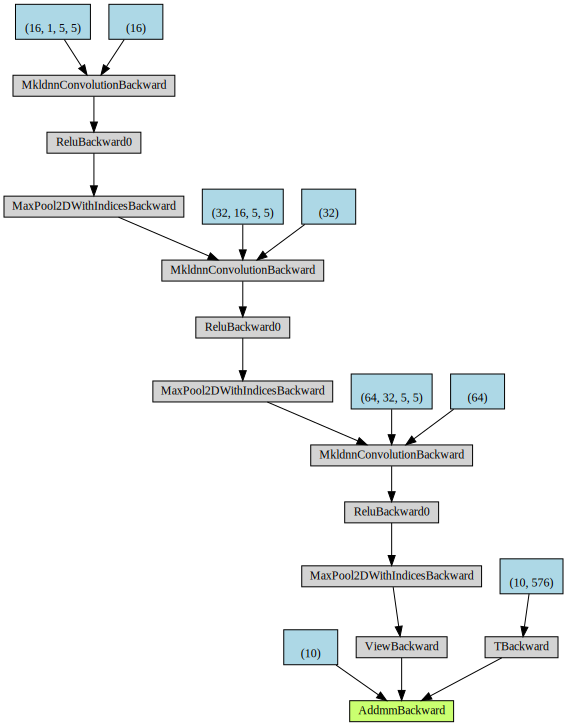

In [23]:
model = Cnn3()
print(model)

x = torch.zeros(1, 1, 28, 28, dtype=torch.float, requires_grad=False)
out = model(x)
make_dot(out)

##Training

In [24]:

#Check if CUDA is enabled
if torch.cuda.is_available():
  model = model.cuda()

train_loader,test_loader = get_loaders(trainset,testset)

#Add Entropy Loss with softmax
criterion = nn.CrossEntropyLoss()

#Use Adam optimizer with Learninng Rate=.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


loss_list_imagenet_total = []
val_list_imagenet_total = []

train_acc_imagenet_total = []
val_acc_imagenet_total = []

correct_train = 0
total_train=0

val_correct_total=0
val_total=0

loss_list_imagenet = []
acc_list_imagenet = []

val_loss_list_imagenet = []
val_acc_list_imagenet = []

for e in range(NUM_OF_EPOCHS):
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        correct_train += correct
        
        total_train += labels.size(0)
        acc_list_imagenet.append(correct)
        loss_list_imagenet.append(loss.item())

        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(e+1, NUM_OF_EPOCHS, i+1, len(train_loader), loss.item()))
    
    loss_list_imagenet_total.append(sum(loss_list_imagenet)/len(loss_list_imagenet))
    train_acc_imagenet_total.append(sum(acc_list_imagenet)/len(acc_list_imagenet))
    model.eval()
    with torch.no_grad():
      for val_images, val_labels in test_loader:
        val_labels = val_labels.cuda()
        val_images = val_images.cuda()
        val_output = model(val_images)
        val_loss = criterion(val_output, val_labels)
        _, val_predicted = torch.max(val_output.data, 1)
        val_correct = (val_predicted == val_labels).sum().item()
        val_correct_total+=val_correct
        val_acc_list_imagenet.append(val_correct)

        val_loss_list_imagenet.append(val_loss.item())
        val_total += val_labels.size(0) 
    val_list_imagenet_total.append(sum(val_loss_list_imagenet)/len(val_loss_list_imagenet))
    val_acc_imagenet_total.append(sum(val_acc_list_imagenet)/len(val_acc_list_imagenet))
    model.train()


Epoch [1/10], Step [100/600], Loss: 0.1886
Epoch [1/10], Step [200/600], Loss: 0.0862
Epoch [1/10], Step [300/600], Loss: 0.0858
Epoch [1/10], Step [400/600], Loss: 0.1144
Epoch [1/10], Step [500/600], Loss: 0.0365
Epoch [1/10], Step [600/600], Loss: 0.0491
Epoch [2/10], Step [100/600], Loss: 0.0344
Epoch [2/10], Step [200/600], Loss: 0.0097
Epoch [2/10], Step [300/600], Loss: 0.0216
Epoch [2/10], Step [400/600], Loss: 0.0370
Epoch [2/10], Step [500/600], Loss: 0.0177
Epoch [2/10], Step [600/600], Loss: 0.0232
Epoch [3/10], Step [100/600], Loss: 0.0842
Epoch [3/10], Step [200/600], Loss: 0.0296
Epoch [3/10], Step [300/600], Loss: 0.0149
Epoch [3/10], Step [400/600], Loss: 0.0354
Epoch [3/10], Step [500/600], Loss: 0.0060
Epoch [3/10], Step [600/600], Loss: 0.0050
Epoch [4/10], Step [100/600], Loss: 0.0123
Epoch [4/10], Step [200/600], Loss: 0.0086
Epoch [4/10], Step [300/600], Loss: 0.0454
Epoch [4/10], Step [400/600], Loss: 0.0096
Epoch [4/10], Step [500/600], Loss: 0.0266
Epoch [4/10

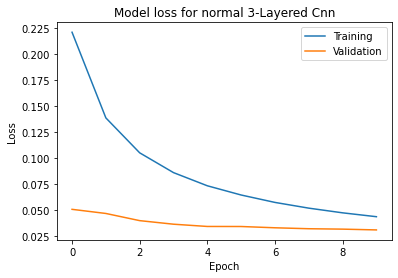

In [25]:
plt.figure()
plt.plot(loss_list_imagenet_total)
plt.plot(val_list_imagenet_total)
plt.title('Model loss for normal 3-Layered Cnn')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')

To train the model, we attach an Adam optimizer with a learning rate of **0.001**. Since the model is not that complicated and yields good results with a higher Learning Rate(0.1) but sometimes the loss explodes and starts diverging instead of converging. So we use a Learning Rate of 0.001

##Test

Test Accuracy of the model on the 10000 test images: 99.29 %


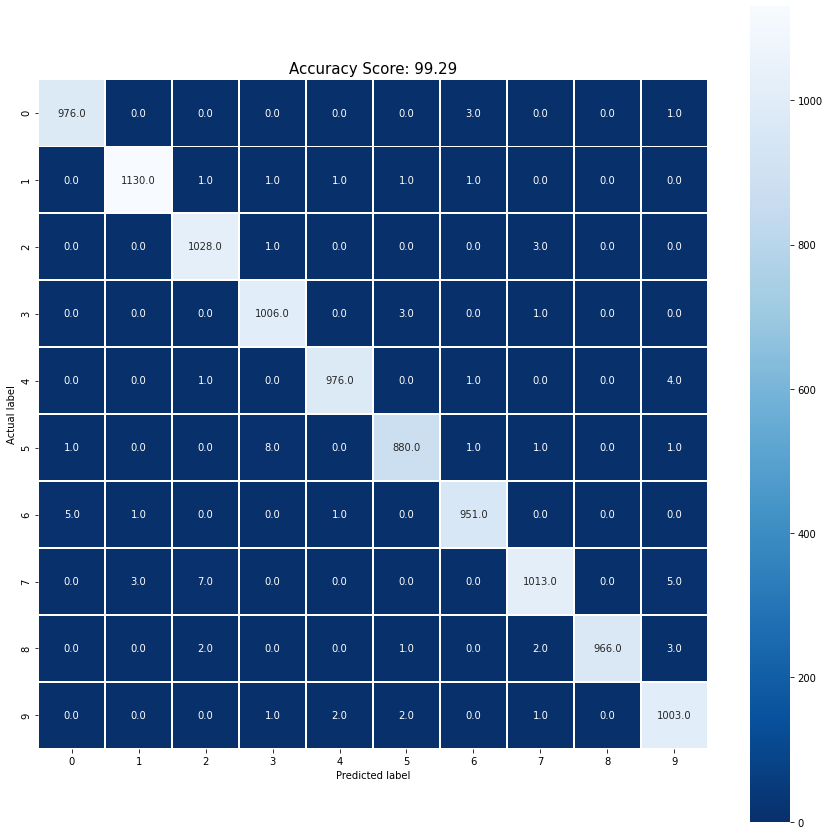

In [26]:
confusion_matrix = torch.zeros(10, 10)

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        outputs = model(images)
        loss = criterion(outputs,labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        pred = (predicted == labels).sum().item()
        correct+=pred
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model_simple.ckpt')
plot_confusion_matrix(confusion_matrix)

A normal 3-Layered Model produces a very good accuracy every time. Since the image size is low and the architecture is optimized enough, we are able to acheive 95-99% accuracy.

# Part 2

#### Data Augmentation

In [27]:
#Create Transformations for the data
#Vertical Shift
tr = transforms.Compose([
     transforms.RandomAffine(degrees=0,translate=(0,0.25)),
     transforms.ToTensor()
 ])
trainset1,testset1 = load_data(DIR_NAME,tr)

#Horizontal Shift
tr = transforms.Compose([
     transforms.RandomAffine(degrees=0,translate=(0.25,0)),
     transforms.ToTensor()
 ])
trainset2,testset2 = load_data(DIR_NAME,tr)

#Rotational Shift
tr = transforms.Compose([
     transforms.RandomRotation(degrees=90),
     transforms.ToTensor()
 ])
trainset3,testset3 = load_data(DIR_NAME,tr)

For Augmentation we are using a Vertical shift with a range of **[-0.25,0.25]**. And another subset of data is shifted Horizontally with the same range as Vertical shift. 

After that we are using a Rotational shift with range of **[-90,90]** degrees. All the transformations are done randomly on the elements and there is no fixed order or seed provided in order to test the robustness of the model.

## Data Concatenation

In [28]:
#Combine Datasets
train_data = ConcatDataset((trainset,trainset1,trainset2,trainset3))
print(train_data.datasets)

test_data = ConcatDataset((testset,testset1,testset2,testset3))

train_loader,test_loader = get_loaders(train_data,test_data)
print(len(train_loader.dataset))
print(len(test_loader.dataset))

[Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor(), Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=(0, 0), translate=(0, 0.25))
               ToTensor()
           ), Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=(0, 0), translate=(0.25, 0))
               ToTensor()
           ), Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-90, 90), resample=False, expand=False)
               ToTensor()
           )]
240000
40000


We can see the four datasets above with the applied transformations and at the bottom we can see the dataset size using `len(train_loader.dataset)` which prints out `240000`, the size of the combined dataset.

## Dropout Model

In [29]:
class Cnn3Dropout(nn.Module):
    
    def __init__(self):
        super(Cnn3Dropout, self).__init__()
        
        self.cnn1 = nn.Conv2d(1,16,kernel_size=5,stride=1,padding=2)
        self.act1 = nn.ReLU()
        self.mp1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.2)
        self.cnn2 = nn.Conv2d(16,32,kernel_size=5,stride=1,padding=2)
        self.act2 = nn.ReLU()
        self.mp2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.2)
        self.cnn3 = nn.Conv2d(32,64,kernel_size=5,stride=1,padding=2)
        self.act3 = nn.ReLU()
        self.mp3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.2)
        self.fullconn = nn.Linear(576,10)

    def forward(self, data):
        result = self.cnn1(data)
        result= self.act1(result)
        result= self.mp1(result)
        result = self.dropout1(result)
        
        result= self.cnn2(result)
        result = self.act2(result)
        result = self.mp2(result)
        result = self.dropout2(result)
        
        result= self.cnn3(result)
        result = self.act3(result)
        result = self.mp3(result)
        result = self.dropout3(result)
        
        result = result.view(result.size(0), -1)
        result = self.fullconn(result)
        
        return result

Now we create a new CNN Model with added Dropouts after every layer with 20% probability of making elements zero after every Convolutional Layer. 

Cnn3(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): ReLU()
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act2): ReLU()
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act3): ReLU()
  (mp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fullconn): Linear(in_features=576, out_features=10, bias=True)
)


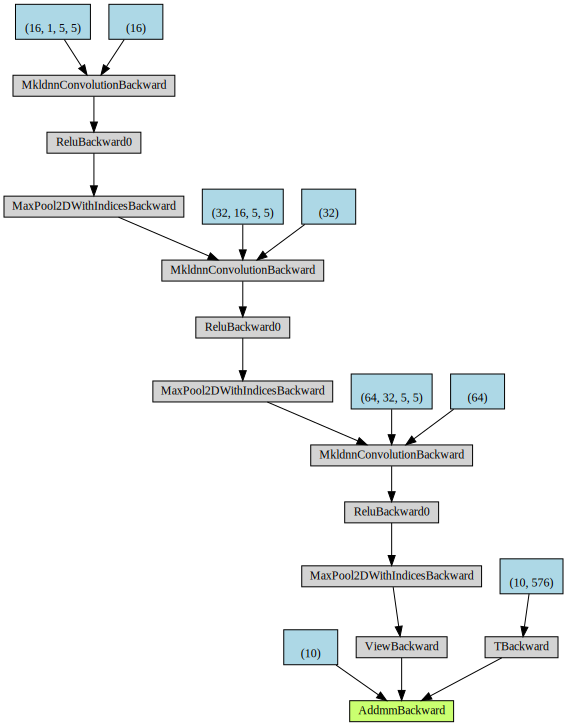

In [30]:
model = Cnn3()
print(model)

x = torch.zeros(1, 1, 28, 28, dtype=torch.float, requires_grad=False)
out = model(x)
make_dot(out)

The model architecture can be seen in above.

## Dropout Regularization

#### Training

In [33]:
model = Cnn3Dropout()
if torch.cuda.is_available():
  model = model.cuda()

#Add Entropy Loss with softmax
criterion = nn.CrossEntropyLoss()

#Use Adam optimizer with LR=.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_list_dropout_total = []
val_list_dropout_total = []

train_acc_dropout_total = []
val_acc_dropout_total = []

correct_train = 0
total_train=0

val_correct_total=0
val_total=0

loss_list_dropout = []
acc_list_dropout = []

val_loss_list_dropout = []
val_acc_list_dropout = []

for e in range(NUM_OF_EPOCHS):
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        correct_train += correct
        
        total_train += labels.size(0)
        acc_list_dropout.append(correct)
        loss_list_dropout.append(loss.item())
                
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(e+1, NUM_OF_EPOCHS, i+1, len(train_loader), loss.item()))
            
    loss_list_dropout_total.append(sum(loss_list_dropout)/len(loss_list_dropout))
    train_acc_dropout_total.append(sum(acc_list_dropout)/len(acc_list_dropout))
    model.eval()
    with torch.no_grad():
      for val_images, val_labels in test_loader:
        val_labels = val_labels.cuda()
        val_images = val_images.cuda()
        val_output = model(val_images)
        val_loss = criterion(val_output, val_labels)
        _, val_predicted = torch.max(val_output.data, 1)
        val_correct = (val_predicted == val_labels).sum().item()
        val_correct_total+=val_correct
        val_acc_list_dropout.append(val_correct)

        val_loss_list_dropout.append(val_loss.item())
        val_total += val_labels.size(0) 
    val_list_dropout_total.append(sum(val_loss_list_dropout)/len(val_loss_list_dropout))
    val_acc_dropout_total.append(sum(val_acc_list_dropout)/len(val_acc_list_dropout))
    model.train()


Epoch [1/10], Step [100/2400], Loss: 0.9718
Epoch [1/10], Step [200/2400], Loss: 0.4891
Epoch [1/10], Step [300/2400], Loss: 0.3089
Epoch [1/10], Step [400/2400], Loss: 0.4230
Epoch [1/10], Step [500/2400], Loss: 0.4800
Epoch [1/10], Step [600/2400], Loss: 0.3696
Epoch [1/10], Step [700/2400], Loss: 0.3679
Epoch [1/10], Step [800/2400], Loss: 0.3374
Epoch [1/10], Step [900/2400], Loss: 0.1918
Epoch [1/10], Step [1000/2400], Loss: 0.1128
Epoch [1/10], Step [1100/2400], Loss: 0.1614
Epoch [1/10], Step [1200/2400], Loss: 0.1576
Epoch [1/10], Step [1300/2400], Loss: 0.0742
Epoch [1/10], Step [1400/2400], Loss: 0.2357
Epoch [1/10], Step [1500/2400], Loss: 0.2336
Epoch [1/10], Step [1600/2400], Loss: 0.1062
Epoch [1/10], Step [1700/2400], Loss: 0.1372
Epoch [1/10], Step [1800/2400], Loss: 0.1180
Epoch [1/10], Step [1900/2400], Loss: 0.0921
Epoch [1/10], Step [2000/2400], Loss: 0.1421
Epoch [1/10], Step [2100/2400], Loss: 0.1257
Epoch [1/10], Step [2200/2400], Loss: 0.2161
Epoch [1/10], Step 

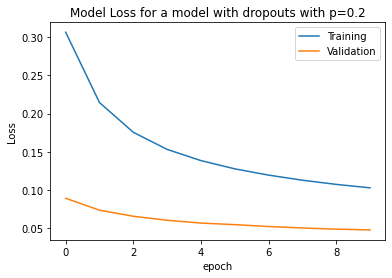

In [35]:
plt.figure()
plt.plot(loss_list_dropout_total)
plt.plot(val_list_dropout_total)
plt.title('Model Loss for a model with dropouts with p=0.2')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='best')

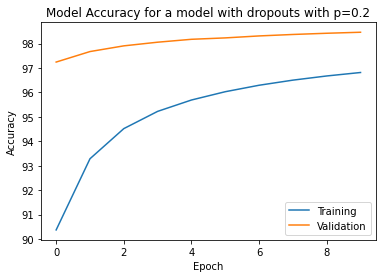

In [36]:
plt.figure()
plt.plot(train_acc_dropout_total)
plt.plot(val_acc_dropout_total)
plt.title('Model Accuracy for a model with dropouts with p=0.2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')

#### Test

Test Accuracy of the model on the 60000 test images: 98.805 %


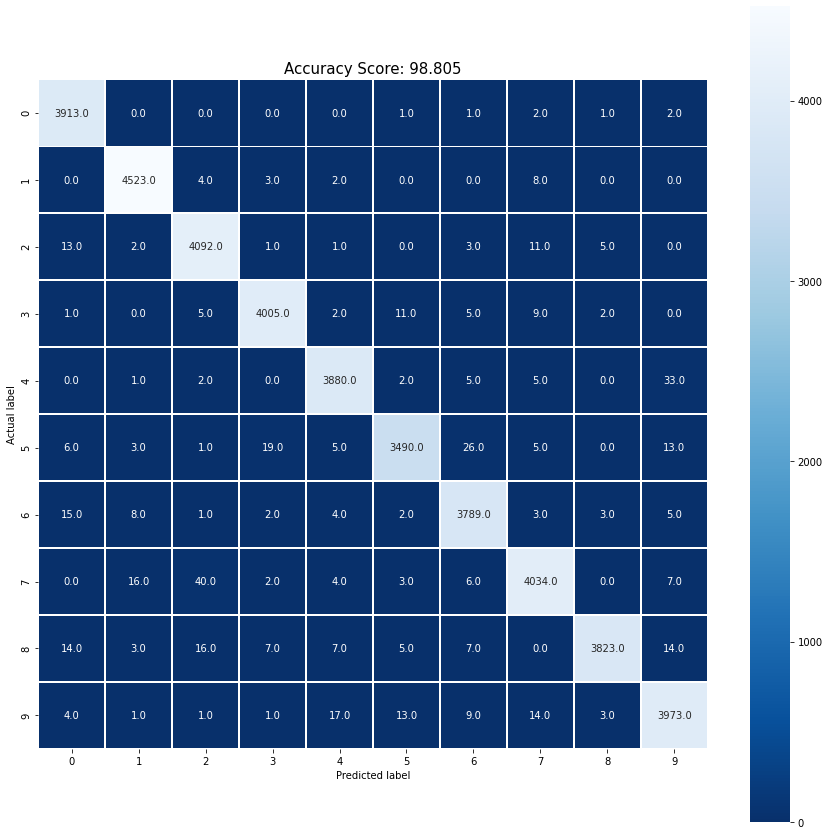

In [37]:
confusion_matrix = torch.zeros(10, 10)
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct+= (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    print('Test Accuracy of the model on the 60000 test images: {} %'.format(100 * correct / total))

# Save model checkpoint
torch.save(model.state_dict(), 'model_dropout.ckpt')
plot_confusion_matrix(confusion_matrix)

## L2 Regularization

To approach with a L2 Regularization model, we provide a `weight_decay` to the model, which is the penalty to be used for penalizing high value parameters.


Also, the model from `Part 1` is used here to display th euseage of only **L2 Regularization**.

#### Training

In [38]:
model = Cnn3()
if torch.cuda.is_available():
          model =model.cuda()

#Add Entropy Loss with softmax
criterion = nn.CrossEntropyLoss()

#Use Adam optimizer with LR=.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.01)

loss_list_reg_total = []
val_list_reg_total = []

train_acc_reg_total = []
val_acc_reg_total = []

correct_train = 0
total_train=0

val_correct_total=0
val_total=0

loss_list_reg = []
acc_list_reg = []

val_loss_list_reg = []
val_acc_list_reg = []

for e in range(NUM_OF_EPOCHS):
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        correct_train += correct
        
        total_train += labels.size(0)
        acc_list_reg.append(correct)
        loss_list_reg.append(loss.item())
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(e+1, NUM_OF_EPOCHS, i+1, len(train_loader), loss.item()))
            
    loss_list_reg_total.append(sum(loss_list_reg)/len(loss_list_reg))
    train_acc_reg_total.append(sum(acc_list_reg)/len(acc_list_reg))
    model.eval()
    with torch.no_grad():
      for val_images, val_labels in test_loader:
        val_labels = val_labels.cuda()
        val_images = val_images.cuda()
        val_output = model(val_images)
        val_loss = criterion(val_output, val_labels)
        _, val_predicted = torch.max(val_output.data, 1)
        val_correct = (val_predicted == val_labels).sum().item()
        val_correct_total+=val_correct
        val_acc_list_reg.append(val_correct)

        val_loss_list_reg.append(val_loss.item())
        val_total += val_labels.size(0) 
    val_list_reg_total.append(sum(val_loss_list_reg)/len(val_loss_list_reg))
    val_acc_reg_total.append(sum(val_acc_list_reg)/len(val_acc_list_reg))
    model.train()


Epoch [1/10], Step [100/2400], Loss: 0.6702
Epoch [1/10], Step [200/2400], Loss: 0.4422
Epoch [1/10], Step [300/2400], Loss: 0.3842
Epoch [1/10], Step [400/2400], Loss: 0.4082
Epoch [1/10], Step [500/2400], Loss: 0.3943
Epoch [1/10], Step [600/2400], Loss: 0.2607
Epoch [1/10], Step [700/2400], Loss: 0.2866
Epoch [1/10], Step [800/2400], Loss: 0.4164
Epoch [1/10], Step [900/2400], Loss: 0.4188
Epoch [1/10], Step [1000/2400], Loss: 0.3764
Epoch [1/10], Step [1100/2400], Loss: 0.1281
Epoch [1/10], Step [1200/2400], Loss: 0.1792
Epoch [1/10], Step [1300/2400], Loss: 0.1923
Epoch [1/10], Step [1400/2400], Loss: 0.3316
Epoch [1/10], Step [1500/2400], Loss: 0.1865
Epoch [1/10], Step [1600/2400], Loss: 0.2020
Epoch [1/10], Step [1700/2400], Loss: 0.1248
Epoch [1/10], Step [1800/2400], Loss: 0.1910
Epoch [1/10], Step [1900/2400], Loss: 0.3288
Epoch [1/10], Step [2000/2400], Loss: 0.2805
Epoch [1/10], Step [2100/2400], Loss: 0.1597
Epoch [1/10], Step [2200/2400], Loss: 0.1999
Epoch [1/10], Step 

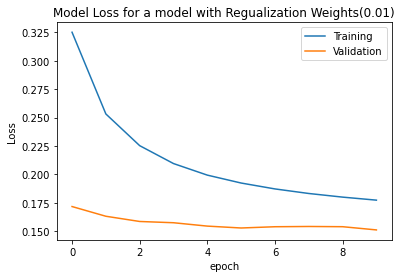

In [39]:
plt.figure()
plt.plot(loss_list_reg_total)
plt.plot(val_list_reg_total)
plt.title('Model Loss for a model with Regualization Weights(0.01)')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='best')

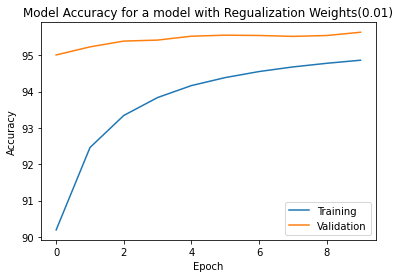

In [40]:
plt.figure()
plt.plot(train_acc_reg_total)
plt.plot(val_acc_reg_total)
plt.title('Model Accuracy for a model with Regualization Weights(0.01)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')

#### Test

Test Accuracy of the model on the 10000 test images: 96.2575 %


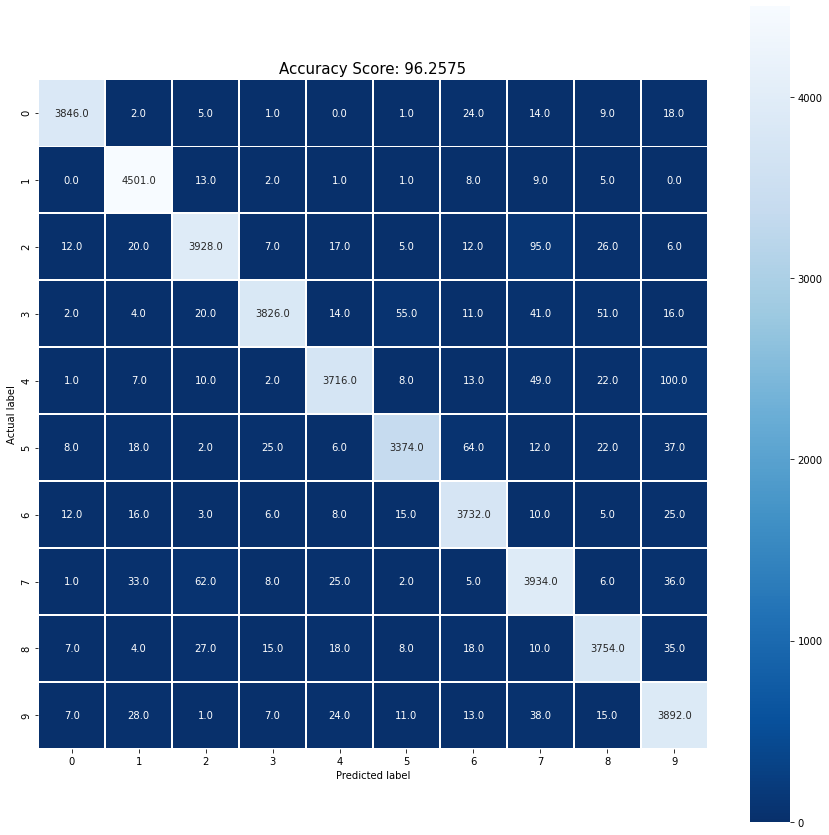

In [41]:
confusion_matrix = torch.zeros(10, 10)

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct+= (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save checkpoint
torch.save(model.state_dict(), 'model_regularized.ckpt')
plot_confusion_matrix(confusion_matrix)

As we can see that the accuracy drops when ran with the model having a L2 regularization. This could be due to the extra penalty for the weights on the network as the dataset is not that complex, so the significant elements are reduced and thus the model becomes less accurate.

A significant difference between the performances of the two techniques can't be figured out as the dataset is small and simple.

In [ ]:
del trainset,testset,test_loader,train_loader,trainset1,trainset2,trainset3,testset1,testset2,testset3

##### Delete all the variables to avoid memory leaks and overheads

# Part 3

#### Data Drive Details

[This link ](https://drive.google.com/drive/folders/1IhiOTrsiCrp1fdGGgi7aSgBjkmWpUQut?usp=sharing) can be used to view/download the data used for the training of Part 3. Also, the code is configured to pick the data from the Google drive, so in order to run the code locally, the occurences of `/content/drive/MyDrive` will needed to be replaced.

## Data Loading

In [ ]:
tr = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])
data = datasets.ImageFolder(root='/content/drive/My Drive/images',transform=tr)
train_set, test_set,validation_set = torch.utils.data.random_split(data, [8000, 1000,1000])
print(len(train_set))
print(len(test_set))
print(len(validation_set))

8000
1000
1000


Before loading the data, we create a few transformations to resize the data into a **224x224** for the sake of ease of computation.

Also, the data is split into 3 subsets of train, test and validation data. 

Text(0.5, 0, 'Image Class: 14')

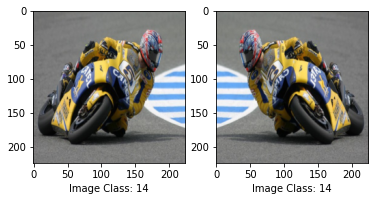

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=100, 
                                           shuffle=True,num_workers=5)
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                           batch_size=100, 
                                           shuffle=False,num_workers=5)
val_loader = torch.utils.data.DataLoader(dataset=validation_set,
                                           batch_size=100, 
                                           shuffle=False,num_workers=5)

img,img1,label = None,None,None
flip_found= False
while not flip_found:
  for i,(images,labels) in enumerate(test_loader):
      if img is None:
        img = images[0]
      elif not torch.equal(img,images[0]):
        img1 = images[0]
        flip_found=True
      label = labels[0]
      break

x = transforms.ToPILImage()

f, axarr = plt.subplots(1,2)
axarr[0].imshow(x(img))
axarr[1].imshow(x(img1))
axarr[0].set_xlabel('Image Class: '+str(label.item()))
axarr[1].set_xlabel('Image Class: '+str(label.item()))


The above image is the resized image.
To avoid overfitting of data, we are randomly filpping the images horizontally.


## Training

In [ ]:
class Cnn5(nn.Module):
    
    def __init__(self):
        super(Cnn5, self).__init__()
        self.cnn1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.act1 = nn.ReLU(inplace=True)
        self.mp1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.cnn2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.act2 = nn.ReLU(inplace=True)
        self.mp2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.cnn3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.act3 = nn.ReLU(inplace=True)
        self.cnn4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.act4 = nn.ReLU(inplace=True)
        self.cnn5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.act5 = nn.ReLU(inplace=True)
        self.mp3 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.drop1 = nn.Dropout()
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.act6 = nn.ReLU(inplace=True)
        self.drop2 = nn.Dropout()
        self.fc2 = nn.Linear(4096, 2048)
        self.act7 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(2048, 20)

    def forward(self, data):
        result = self.cnn1(data)
        result =self.act1(result)
        result =self.mp1(result)
        result =self.cnn2(result)
        result =self.act2(result)
        result =self.mp2(result)
        result =self.cnn3(result)
        result =self.act3(result)
        result =self.cnn4(result)
        result =self.act4(result)
        result =self.cnn5(result)
        result =self.act5(result)
        result =self.mp3(result)
        
        result =self.avgpool(result)
        result = torch.flatten(result, 1)
        result =self.drop1(result)
        result =self.fc1(result)
        result =self.act6(result)
        result =self.drop2(result)
        result =self.fc2(result)
        result =self.act7(result)
        result =self.fc3(result)
        return result

In [ ]:
model = Cnn5()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


#Add Entropy Loss with softmax
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01,weight_decay=0.0006,momentum=0.9)


loss_list_imagenet_total = []
val_list_imagenet_total = []

train_acc_imagenet_total = []
val_acc_imagenet_total = []

correct_train = 0
total_train=0

val_correct_total=0
val_total=0

loss_list_imagenet = []
acc_list_imagenet = []

val_loss_list_imagenet = []
val_acc_list_imagenet = []

NUM_OF_EPOCHS=50

for e in range(NUM_OF_EPOCHS):
  start_time = time.time()
  for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
          labels = labels.cuda()
          images = images.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        correct_train += correct
        
        total_train += labels.size(0)
        acc_list_imagenet.append(correct)
        loss_list_imagenet.append(loss.item())
        
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
          .format(e+1, NUM_OF_EPOCHS, i+1, len(train_loader), loss.item()))
        
        
  loss_list_imagenet_total.append(sum(loss_list_imagenet)/len(loss_list_imagenet))
  train_acc_imagenet_total.append(sum(acc_list_imagenet)/len(acc_list_imagenet))
  model.eval()
  with torch.no_grad():
    for val_images, val_labels in val_loader:
      if torch.cuda.is_available():
        val_labels = val_labels.cuda()
        val_images = val_images.cuda()
      val_output = model(val_images)
      val_loss = criterion(val_output, val_labels)
      _, val_predicted = torch.max(val_output.data, 1)
      val_correct = (val_predicted == val_labels).sum().item()
      val_correct_total+=val_correct
      val_acc_list_imagenet.append(val_correct)

      val_loss_list_imagenet.append(val_loss.item())
      val_total += val_labels.size(0) 
  val_list_imagenet_total.append(sum(val_loss_list_imagenet)/len(val_loss_list_imagenet))
  val_acc_imagenet_total.append(sum(val_acc_list_imagenet)/len(val_acc_list_imagenet))

  model.train()

  print('Train accuracy: '+ str((100 * correct_train / total_train)))
  print('Val accuracy: '+ str((100 * val_correct_total / val_total)))
  print('Time Taken for this epoch: '+ str(time.time()-start_time))

Epoch [1/50], Step [1/80], Loss: 2.9944
Epoch [1/50], Step [2/80], Loss: 2.9986
Epoch [1/50], Step [3/80], Loss: 2.9945
Epoch [1/50], Step [4/80], Loss: 2.9949
Epoch [1/50], Step [5/80], Loss: 2.9974
Epoch [1/50], Step [6/80], Loss: 2.9958
Epoch [1/50], Step [7/80], Loss: 2.9978
Epoch [1/50], Step [8/80], Loss: 2.9935
Epoch [1/50], Step [9/80], Loss: 2.9973
Epoch [1/50], Step [10/80], Loss: 2.9970
Epoch [1/50], Step [11/80], Loss: 2.9978
Epoch [1/50], Step [12/80], Loss: 2.9947
Epoch [1/50], Step [13/80], Loss: 2.9949
Epoch [1/50], Step [14/80], Loss: 2.9947
Epoch [1/50], Step [15/80], Loss: 2.9957
Epoch [1/50], Step [16/80], Loss: 2.9953
Epoch [1/50], Step [17/80], Loss: 2.9952
Epoch [1/50], Step [18/80], Loss: 2.9979
Epoch [1/50], Step [19/80], Loss: 2.9966
Epoch [1/50], Step [20/80], Loss: 2.9950
Epoch [1/50], Step [21/80], Loss: 2.9970
Epoch [1/50], Step [22/80], Loss: 2.9965
Epoch [1/50], Step [23/80], Loss: 2.9956
Epoch [1/50], Step [24/80], Loss: 2.9951
Epoch [1/50], Step [25/80

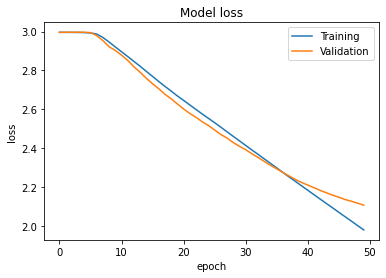

In [ ]:
plt.figure()
plt.plot(loss_list_imagenet_total)
plt.plot(val_list_imagenet_total)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='best')

## Test

Test Accuracy of the model on the 1000 test images: 53.0 %


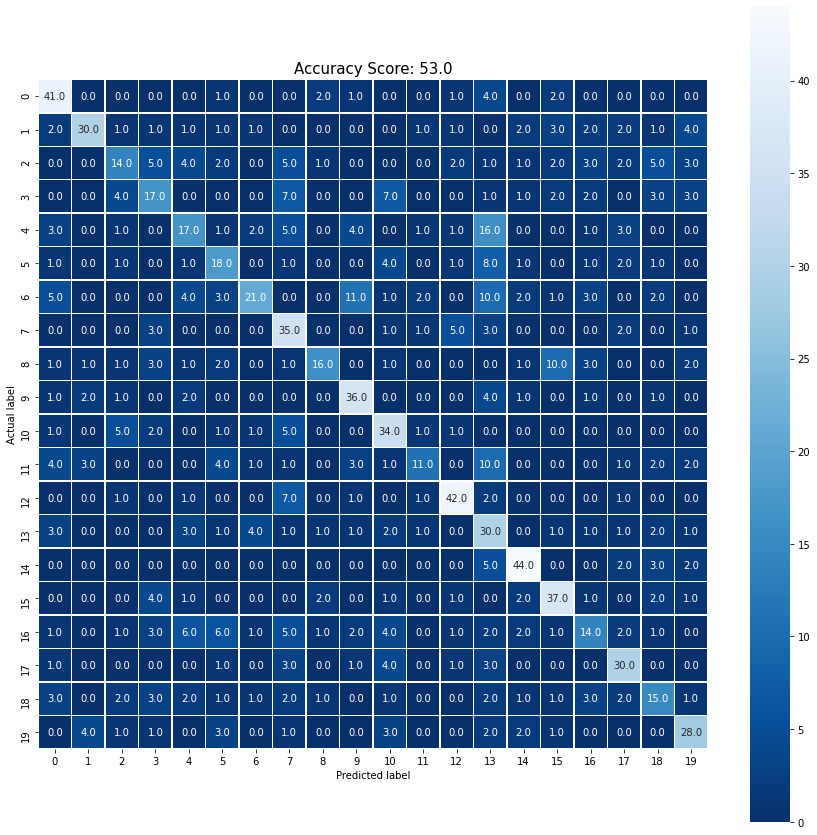

In [ ]:
confusion_matrix = torch.zeros(20, 20)
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct+= (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    print('Test Accuracy of the model on the 1000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), '/content/drive/My Drive/model_imagenet52.ckpt')
plot_confusion_matrix(confusion_matrix)


After many tries, we acheived an accuracy of above 50% by experimenting with the learning rates and the weight decays. 

Also, we tried a different number of training epochs in order to converge but most of the time, the model started overfitting after a few epochs.

So finally we decided to switch to Stochastic Gradient Descent as our optimizer with **Learning rate of 0.01** and a **L2 Regularization weight of 0.0006** with 50 epochs.

The above parameters proved to be the best combination as we can see from the Loss graph that there are no signs of overfitting or underfitting.

The horizontal flipping of images helped a lot since the data became a bit noisy and made the model work hard in order to cover all the different features.